# Improved Exploration

Lets analyze how the traditional q-learning agent fares against the a similar agent that uses an improved exploration policy, and our ODP agent. It is expected that q-learning will be considerably worse, since it is not taking advantage about the specific problem. To recap:

* Q-learning: generic algorithm, that can be applied to the general problem of reinforcement learning
* Q-explorer: very similar to q-learning, except we use an improved exploration, by kepping a map of the world, and avoiding actions that are surely bad.
* ODP: an agent focused on finding the optimal path with as little exploration as possible. It keeps a map of the world, and uses dynamic programming to find paths to our goal, by making an "optimistic" assumption of the world based on the map.

In [1]:
import sys 
sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt

from grid_world.action import Action
from grid_world.grid_world import GridWorld
from grid_world.agents.q_explorer_agent import QExplorerAgent
from grid_world.agents.q_agent import QAgent
from grid_world.agents.odp_agent import ODPAgent
from grid_world.visualization.format_objects import get_policy_rec_str, get_policy_eval_str, get_world_str
from grid_world.utils.returns import returns_from_reward
from grid_world.utils.policy import get_policy_rec, get_random_policy, sample_action

np.random.seed(21)

In [2]:
gworld = GridWorld(
    grid_shape=(4,5), 
    terminal_states_coordinates=((0,4),),
    walls_coordinates=((0,1), (1,1), (2,3)),
    traps_coordinates=((1,3),),
)
print(get_world_str(gworld))

3               

2          █    

1    █     ☠    

0 ⚐  █        ✘ 

  0  1  2  3  4 


In [3]:
def reward(e):
    if e == 1:
        return 0
    elif e == -1:
        return -100
    else:
        return -1

base_actions = [Action.up, Action.down, Action.left, Action.right]
epsilon = .1
alpha = .3

In [4]:
training_rounds = 50

qe_returns = []

for _ in range(training_rounds):
    qe_agent = QExplorerAgent(
        reward_function = reward,
        actions = base_actions,
        gamma = 1,
        alpha = alpha,
        epsilon = epsilon
    )

    qe_episode_lengths, qe_episode_returns = qe_agent.train(world = gworld, episodes = 100)
    qe_returns.append(qe_episode_returns)
    
qe_pi_r = get_policy_rec(qe_agent.policy, gworld, qe_agent.actions)
qe_average_returns = np.mean(np.array(qe_returns), axis=0)
qe_std_returns = np.std(np.array(qe_returns), axis=0)
print(get_policy_rec_str(qe_pi_r, gworld))

 →  ↓  →  →  ↓ 

 →  →  ↓  █  ↓ 

 ↑  █  ↓  ☠  ↓ 

 ↑  █  →  →  ✘ 




In [5]:
training_rounds = 50

q_returns = []

for _ in range(training_rounds):
    q_agent = QAgent(
        world = gworld,
        reward_function = reward,
        actions = base_actions,
        gamma = 1,
        alpha = alpha,
        epsilon = epsilon
    )

    q_episode_lengths, q_episode_returns = q_agent.train(episodes = 100)
    q_returns.append(q_episode_returns)
    
q_pi_r = get_policy_rec(q_agent.policy, gworld, q_agent.actions)
q_average_returns = np.mean(np.array(q_returns), axis=0)
q_std_returns = np.std(np.array(q_returns), axis=0)
print(get_policy_rec_str(q_pi_r, gworld))

 ←  ↓  ↓  →  ↓ 

 →  →  ↓  █  ↓ 

 ↑  █  ↓  ☠  ↓ 

 ↑  █  →  →  ✘ 




In [6]:
odp_agent = ODPAgent(
    reward_function = reward,
    actions = base_actions,
    gamma = 1,
    world_height = 4,
    world_length = 5,

)

odp_episode_lengths, odp_episode_returns = odp_agent.train(world = gworld, episodes = 100)
    
odp_pi_r = get_policy_rec(odp_agent.policy, gworld, odp_agent.actions)
print(get_policy_rec_str(odp_pi_r, gworld))

 ↓  ↓  ↓  →  ↓ 

 →  →  ↓  █  ↓ 

 ↑  █  ↓  ☠  ↓ 

 ↑  █  →  →  ✘ 




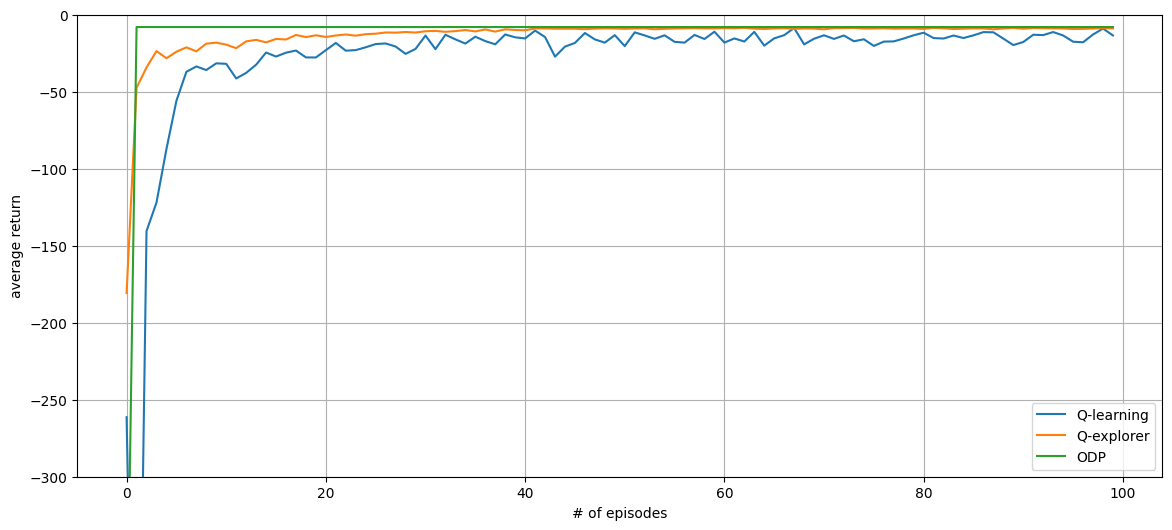

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(q_average_returns, label = "Q-learning")
ax.plot(qe_average_returns, label = "Q-explorer")
ax.plot(odp_episode_returns, label = "ODP")

ax.set(
    xlabel='# of episodes', 
    ylabel='average return', 
    ylim=[-300, 0]
)
ax.grid()
ax.legend(loc="lower right")

plt.show()

In [8]:
print(f"""
Average accumulated return

Q-learning: {np.mean(q_average_returns):.2f}
Q-explorer: {np.mean(qe_average_returns):.2f}
ODP: {np.mean(odp_episode_returns):.2f}

Average accumulated return of last 10 episodes

Q-learning: {np.mean(q_average_returns[-10:]):.2f}
Q-explorer: {np.mean(qe_average_returns[-10:]):.2f}
ODP: {np.mean(odp_episode_returns[-10:]):.2f}

""")


Average accumulated return

Q-learning: -29.81
Q-explorer: -13.54
ODP: -12.29

Average accumulated return of last 10 episodes

Q-learning: -13.93
Q-explorer: -8.94
ODP: -8.00




Results go as expected! ODP finds an optimal path very fast. Q-explorer also shows good results, with less variance and better expected results.

## Bigger world

In [9]:
gworld = GridWorld(
    grid_shape=(8,10), 
    terminal_states_coordinates=((5,6),),
    walls_coordinates=(
        (1,1), (2,1), (3,1), (5,1), (5,2), (5,4), (5,5), (3,3), (3,4), (3,5), (3,6), (2,6), (1,6),
        (7,0), (7,1),(7,2), (7,3), (7,4), (6,6), (6,7), (6,8), (5,8),
        (1,7), (1, 8), (3, 8), (3, 9), (0,3)
    ),
    traps_coordinates=((1,3),(1,4),(4,5)),
)
print(get_world_str(gworld))

7 █  █  █  █  █                

6                   █  █  █    

5    █  █     █  █  ✘     █    

4                ☠             

3    █     █  █  █  █     █  █ 

2    █              █          

1    █     ☠  ☠     █  █  █    

0 ⚐        █                   

  0  1  2  3  4  5  6  7  8  9 


In [10]:
training_rounds = 20

q_returns = []

for _ in range(training_rounds):
    q_agent = QAgent(
        world = gworld,
        reward_function = reward,
        actions = base_actions,
        gamma = 1,
        alpha = alpha,
        epsilon = epsilon
    )

    q_episode_lengths, q_episode_returns = q_agent.train(episodes = 200)
    q_returns.append(q_episode_returns)
    
q_pi_r = get_policy_rec(q_agent.policy, gworld, q_agent.actions)
q_average_returns = np.mean(np.array(q_returns), axis=0)
q_std_returns = np.std(np.array(q_returns), axis=0)
print(get_policy_rec_str(q_pi_r, gworld))

 █  █  █  █  █  →  →  →  →  ↓ 

 ←  →  ↓  →  →  ↑  █  █  █  ↓ 

 ←  █  █  ↑  █  █  ✘  ←  █  ↓ 

 ↑  →  →  ↑  ↑  ☠  ↑  ↑  ←  ← 

 ↑  █  ↓  █  █  █  █  ↑  █  █ 

 ↑  █  →  →  →  ↓  █  ↑  ←  ← 

 ↓  █  ↑  ☠  ☠  ↓  █  █  █  ↑ 

 →  →  ↑  █  ←  →  →  →  →  ↑ 




In [11]:
training_rounds = 20

qe_returns = []

for _ in range(training_rounds):
    qe_agent = QExplorerAgent(
        reward_function = reward,
        actions = base_actions,
        gamma = 1,
        alpha = alpha,
        epsilon = epsilon
    )

    qe_episode_lengths, qe_episode_returns = qe_agent.train(world = gworld, episodes = 200)
    qe_returns.append(qe_episode_returns)
    
qe_pi_r = get_policy_rec(qe_agent.policy, gworld, qe_agent.actions)
qe_average_returns = np.mean(np.array(qe_returns), axis=0)
qe_std_returns = np.std(np.array(qe_returns), axis=0)
print(get_policy_rec_str(qe_pi_r, gworld))

 █  █  █  █  █  →  →  →  →  ↓ 

 →  →  →  →  →  ↑  █  █  █  ↓ 

 ↑  █  █  ↑  █  █  ✘  ←  █  ↓ 

 ↓  →  ↓  ↑  ←  ☠  ↑  ←  ←  ← 

 ↑  █  ↑  █  █  █  █  ↑  █  █ 

 ↑  █  →  →  →  ↓  █  ↑  ←  ← 

 ↑  █  ↑  ☠  ☠  ↓  █  █  █  ↑ 

 →  →  ↑  █  →  →  →  →  →  ↑ 




In [12]:
odp_agent = ODPAgent(
    reward_function = reward,
    actions = base_actions,
    gamma = 1,
    world_height = 8,
    world_length = 10,
)

odp_episode_lengths, odp_episode_returns = odp_agent.train(world = gworld, episodes = 200, verbose = True)
    
odp_pi_r = get_policy_rec(odp_agent.policy, gworld, odp_agent.actions)
print(get_policy_rec_str(odp_pi_r, gworld))

policy converged in 3 epochs
policy converged in 5 epochs
policy converged in 5 epochs
policy converged in 3 epochs
policy converged in 3 epochs
policy converged in 3 epochs
policy converged in 4 epochs
 █  █  █  █  █  →  →  →  →  ↓ 

 →  →  →  →  →  ↑  █  █  █  ↓ 

 ↑  █  █  ↑  █  █  ✘  ←  █  ↓ 

 ↑  →  →  ↑  ←  ☠  ↑  ↑  ←  ← 

 ↑  █  ↑  █  █  █  █  ↑  █  █ 

 ↑  █  →  →  →  ↓  █  ↑  ←  ← 

 ↑  █  ↑  ☠  ☠  ↓  █  █  █  ↑ 

 →  →  ↑  █  →  →  →  →  →  ↑ 




In [14]:
optimistic_world = odp_agent.build_opt_world()
pi_r = get_policy_rec(odp_agent.policy, odp_agent.build_opt_world(), odp_agent.actions)
print(get_policy_rec_str(pi_r, optimistic_world))

 █  █  █  █  █  →  →  →  →  ↓ 

 →  →  →  →  →  ↑  █  █  █  ↓ 

 ↑  █  █  ↑  █  █  ✘  ←  █  ↓ 

 ↑  →  →  ↑  ←  ☠  ↑  ↑  ←  ← 

 ↑  █  ↑  █  █  █  ↑  ↑  █  █ 

 ↑  █  →  →  →  ↓  █  ↑  ←  ← 

 ↑  █  ↑  ☠  ☠  ↓  █  █  █  ↑ 

 →  →  ↑  █  →  →  →  →  →  ↑ 




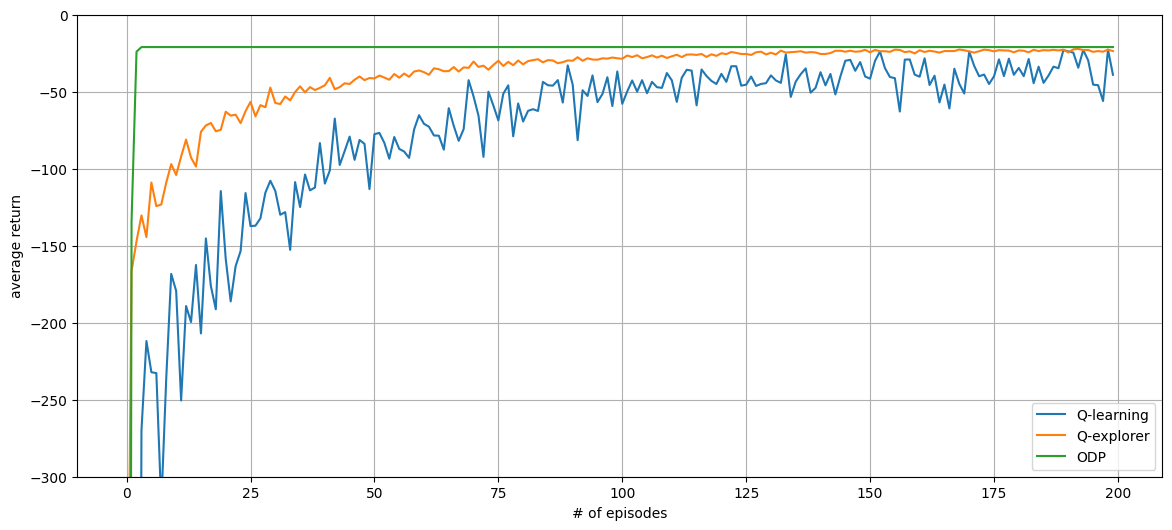

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(q_average_returns, label = "Q-learning")
ax.plot(qe_average_returns, label = "Q-explorer")
ax.plot(odp_episode_returns, label = "ODP")

ax.set(
    xlabel='# of episodes', 
    ylabel='average return', 
    ylim=[-300, 0]
)
ax.grid()
ax.legend(loc="lower right")

plt.show()

In [17]:
print(f"""
Average accumulated return

Q-learning: {np.mean(q_average_returns):.2f}
Q-explorer: {np.mean(qe_average_returns):.2f}
ODP: {np.mean(odp_episode_returns):.2f}

Average accumulated return of last 10 episodes

Q-learning: {np.mean(q_average_returns[-10:]):.2f}
Q-explorer: {np.mean(qe_average_returns[-10:]):.2f}
ODP: {np.mean(odp_episode_returns[-10:]):.2f}

""")


Average accumulated return

Q-learning: -89.23
Q-explorer: -40.92
ODP: -30.49

Average accumulated return of last 10 episodes

Q-learning: -34.42
Q-explorer: -23.31
ODP: -21.00




Again there are no big surprises here. ODP finds an optimal path and sticks to it. While q-explorer shows good improvements over q-learning.

An important point is that, although ODP is very good in terms of "data efficiency", it is more computationally expensive. In this example it required solving the DP problem 7 times. It is also curious that the agent had to explore almost the entire maze before finding a final solution. Because of that it has an optimal policy in every state, this is however particular to this example. In general the agent is only garanted to find an optimal path, but may have a bad policy at other states.